In [1]:
import numpy as np
import matplotlib.pyplot as plt
from oracle import Oracle
from accuracy_test import accuracy_check, accuracy_check_iter, accuracy_check_err
import time

In [2]:
def decentralizedSGD(x0, lr, max_iter, eps, W, oracle):
    
    x_t = x0
    x_prev = x0
    
    itr = 0
    error = np.inf
    current_sum = 0.
    
    errors = []
    
    x_star, _ = oracle.getMin()
    
    while (itr < max_iter) and (error > eps):
         
        noise = np.random.normal(0, 1, size=x_t.shape) / 100
        
        f, df = oracle(x_t + noise)
        
        x_prev = x_t
        
        y_t = x_t - lr * df
        x_t = y_t @ W
        
        '''
        if (oracle.getType() == "strongly convex") and (itr > 0):
            err, sum_ = accuracy_check_iter(x_prev, current_sum, itr, oracle, x_t)
            error = err
            current_sum = sum_
            errors.append(error)
        elif (oracle.getType() != "strongly convex"):
            err, sum_ = accuracy_check_iter(x_t, current_sum, itr, oracle)
            error = err
            current_sum = sum_
            errors.append(error)
        '''
        
        error = accuracy_check_err(x_t, x_star)
        errors.append(error)
         
        itr += 1
        
    return x_t, itr, errors

def MetropolisHastings(W):
    
    degrees = np.sum(W, axis=1)
    
    for i in range(W.shape[0]):
        for j in range(i+1, W.shape[0]):
            
            if W[i, j] != 0:
                
                weight = 1 / (1 + max(degrees[i], degrees[j]))
                
                W[i, j] = weight
                W[j, i] = weight
    
    for i in range(W.shape[0]):
        if W[i, i] != 0:
            W[i, i] = 1 - (np.sum(W, axis = 0)[i] - 1.0) # Remove 1 because counts self weight of 1 from adjacency matrix W
                
    return W


def toMatrix(n_nodes, adj_list):
    
    matrix = np.zeros((n_nodes, n_nodes))
    
    for node in adj_list:
        
        neighbors = adj_list[node]
        
        for neighbor in neighbors:
            
            matrix[node, neighbor] = 1
            matrix[neighbor, node] = 1
            
    return matrix.astype(np.float64)


def buildTopology(n_nodes, topology):
    
    if topology == "dense":
        
        W = np.ones((n_nodes, n_nodes))

        return MetropolisHastings(W.astype(np.float64))
    
    elif topology == "ring":
        
        connections = {} # adjacency list
        
        for node in range(n_nodes):
            
            if node == n_nodes - 1:
                connections[node] = [node, 0]
            else:
                connections[node] = [node, node + 1]
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    elif topology == "centralized":
        
        connections = {} # adjacency list
        
        connections[0] = [0]
        for node in range(1, n_nodes):
            connections[node] = [node, 0] # node 0 is central node
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    elif topology == "path":
        
        connections = {} # adjacency list
        
        for node in range(n_nodes):
            
            if node != n_nodes - 1:
                connections[node] = [node, node + 1]
            else:
                connections[node] = [node]
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    else:
        print("Wrong topology")
        

def experiment(list_nodes, n_params, topology, func_type, max_iter, lr, error_threshold, number_exp = 10):
    
    means = []
    results = []
    
    oracle = Oracle(func_type, n_params)
    
    for n_nodes in list_nodes:
        start = time.time()
        
        print("Starting experiment on {} nodes.".format(n_nodes))
        
        temp = []
        
        for _ in range(number_exp): # Do average
            
            x0 = np.ones((n_params, n_nodes)).astype(np.float64) #np.random.randn(n_params, n_nodes)
            W = buildTopology(n_nodes, topology)
            
            x_t, itr, errors = decentralizedSGD(x0, lr, max_iter, error_threshold, W, oracle)

            temp.append(itr)
        
        mean = np.mean(temp)
        
        print(f'DEBUG num.nides {n_nodes} time {time.time() - start}')
        print("Converged within {} in {} iterations on average.".format(error_threshold, mean))
        print()
        
        means.append(mean)
        results.append(temp)
    
    return np.array(means), np.array(results)
    

def plotIter(num_nodes, iters):
    
    plt.plot(num_nodes, iters)
    plt.xlabel("Number of nodes")
    plt.ylabel("Number of iterations")
    plt.show()

# Experiments

In [3]:
save_folder = "data/"

n_params = 10
max_iter = np.inf
number_exp = 5

num_nodes = [2, 10, 50, 100, 300, 600, 1000, 1200]

## Non convex function

In [4]:
func_type = "non convex"

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 0.052110910415649414
Converged within 1e-05 in 158.6 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.01985621452331543
Converged within 1e-05 in 71.0 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.08078598976135254
Converged within 1e-05 in 69.6 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 0.14462900161743164
Converged within 1e-05 in 69.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 0.4391508102416992
Converged within 1e-05 in 68.8 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 2.0226199626922607
Converged within 1e-05 in 69.0 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 6.621642827987671
Converged within 1e-05 in 68.8 iterations on average.

Starting experiment on 1200 nodes.
DEBUG num.nides 1200 time 10.649955

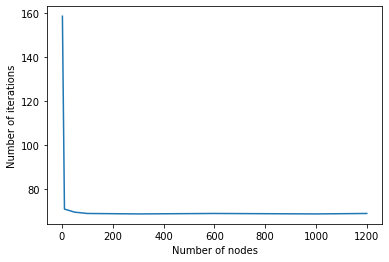

data/nonconvex_dense.npy


In [5]:
topology = "dense"
lr = 1e-1
threshold = 1e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 0.3692290782928467
Converged within 1e-05 in 155.8 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.5524649620056152
Converged within 1e-05 in 137.8 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 2.5502419471740723
Converged within 1e-05 in 140.2 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 4.907481670379639
Converged within 1e-05 in 140.2 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 14.024363994598389
Converged within 1e-05 in 140.0 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 24.952467918395996
Converged within 1e-05 in 139.6 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 45.724998235702515
Converged within 1e-05 in 139.6 iterations on average.

Starting experiment on 1200 nodes.
DEBUG num.nides 1200 time 57.84148

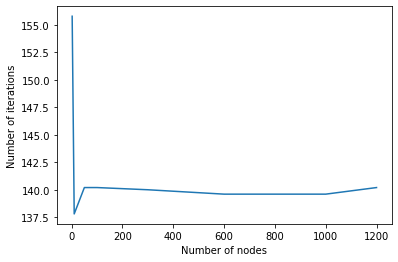

data/convex_ring.npy


In [21]:
topology = "ring"
lr = 1e-1
threshold = 1e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 0.0304720401763916
Converged within 5e-05 in 63.4 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.024667739868164062
Converged within 5e-05 in 65.6 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.03751707077026367
Converged within 5e-05 in 70.2 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 0.05381298065185547
Converged within 5e-05 in 71.6 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 0.3573288917541504
Converged within 5e-05 in 83.8 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 1.0810081958770752
Converged within 5e-05 in 151.4 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 7.935612916946411
Converged within 5e-05 in 583.4 iterations on average.

Starting experiment on 1200 nodes.
DEBUG num.nides 1200 time 61.767867

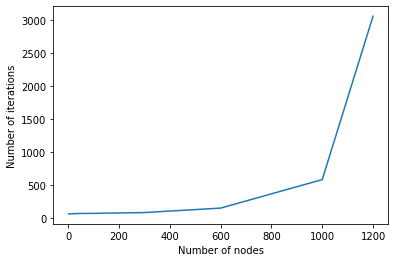

data/nonconvex_centralized.npy


In [9]:
topology = "centralized"
lr = 1e-1
threshold = 5e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

## Convex function

In [12]:
func_type = "convex"

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 0.3502027988433838
Converged within 1e-05 in 155.0 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.5787200927734375
Converged within 1e-05 in 136.8 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 2.2872681617736816
Converged within 1e-05 in 134.2 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 3.9597129821777344
Converged within 1e-05 in 133.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 15.25686502456665
Converged within 1e-05 in 133.8 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 38.70440101623535
Converged within 1e-05 in 134.0 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 49.155522108078
Converged within 1e-05 in 133.6 iterations on average.

Starting experiment on 1200 nodes.
DEBUG num.nides 1200 time 75.238225936

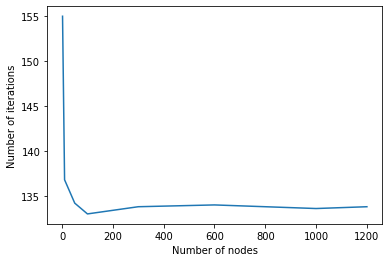

data/convex_dense.npy


In [13]:
topology = "dense"
lr = 1e-1
threshold = 1e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 0.273557186126709
Converged within 1e-05 in 166.2 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.5316669940948486
Converged within 1e-05 in 142.8 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 2.332669973373413
Converged within 1e-05 in 141.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 4.270441055297852
Converged within 1e-05 in 142.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 12.54292607307434
Converged within 1e-05 in 141.8 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 28.57764196395874
Converged within 1e-05 in 142.2 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 50.48414492607117
Converged within 1e-05 in 141.8 iterations on average.

Starting experiment on 1200 nodes.
DEBUG num.nides 1200 time 57.6135799884

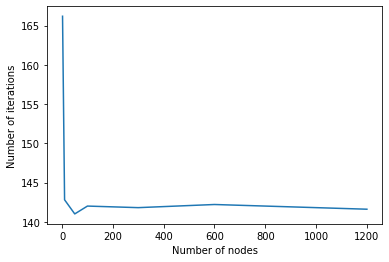

data/convex_ring.npy


In [22]:
topology = "ring"
lr = 1e-1
threshold = 1e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 0.21062135696411133
Converged within 5e-05 in 128.4 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.6385040283203125
Converged within 5e-05 in 128.0 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 2.0819640159606934
Converged within 5e-05 in 130.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 4.776073932647705
Converged within 5e-05 in 130.6 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 14.492549180984497
Converged within 5e-05 in 132.2 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 26.95932412147522
Converged within 5e-05 in 132.8 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 55.3136830329895
Converged within 5e-05 in 133.0 iterations on average.

Starting experiment on 1200 nodes.
DEBUG num.nides 1200 time 64.2971410

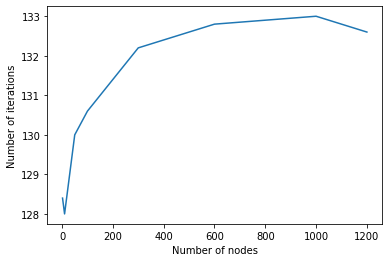

data/convex_centralized.npy


In [16]:
topology = "centralized"
lr = 1e-1
threshold = 5e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

## Strongly convex function

In [17]:
func_type = "convex"

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 0.25772595405578613
Converged within 1e-05 in 158.6 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.5723907947540283
Converged within 1e-05 in 142.8 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 2.0882439613342285
Converged within 1e-05 in 138.4 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 3.926328182220459
Converged within 1e-05 in 137.8 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 12.734405040740967
Converged within 1e-05 in 138.8 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 26.83608078956604
Converged within 1e-05 in 138.2 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 49.958641052246094
Converged within 1e-05 in 138.4 iterations on average.

Starting experiment on 1200 nodes.
DEBUG num.nides 1200 time 64.46320

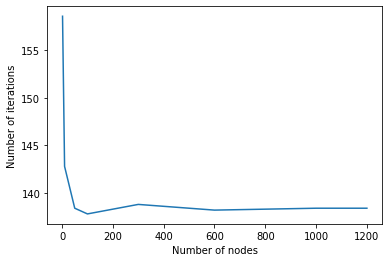

data/convex_dense.npy


In [18]:
topology = "dense"
lr = 1e-1
threshold = 1e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 0.26242995262145996
Converged within 1e-05 in 174.2 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.6132409572601318
Converged within 1e-05 in 146.6 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 2.177927017211914
Converged within 1e-05 in 146.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 5.925350904464722
Converged within 1e-05 in 145.8 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 13.479661703109741
Converged within 1e-05 in 145.2 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 32.65996694564819
Converged within 1e-05 in 144.4 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 52.523518085479736
Converged within 1e-05 in 144.8 iterations on average.

Starting experiment on 1200 nodes.
DEBUG num.nides 1200 time 62.821763

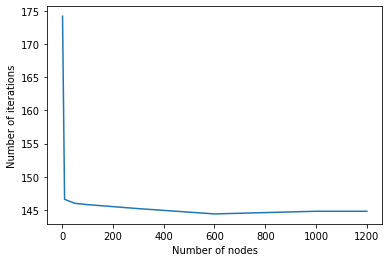

data/convex_ring.npy


In [23]:
topology = "ring"
lr = 1e-1
threshold = 1e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 2 nodes.
DEBUG num.nides 2 time 0.20150208473205566
Converged within 5e-05 in 129.6 iterations on average.

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.45746397972106934
Converged within 5e-05 in 126.4 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 2.018012046813965
Converged within 5e-05 in 130.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 3.8197312355041504
Converged within 5e-05 in 131.6 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 14.189636707305908
Converged within 5e-05 in 132.4 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 39.662437915802
Converged within 5e-05 in 132.8 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 62.065791845321655
Converged within 5e-05 in 132.8 iterations on average.

Starting experiment on 1200 nodes.
DEBUG num.nides 1200 time 72.843199

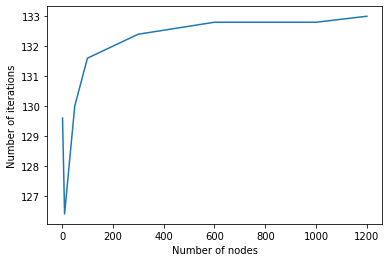

data/convex_centralized.npy


In [20]:
topology = "centralized"
lr = 1e-1
threshold = 5e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

In [24]:
print(results)

[[162 147 144 270 148]
 [149 145 151 150 138]
 [143 145 144 150 148]
 [145 144 146 149 145]
 [145 145 146 145 145]
 [145 145 144 145 143]
 [145 145 145 144 145]
 [145 145 144 145 145]]
